In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

This Notebook serves the following two purposes:
- To code our Gradient Descent in vectorised form for a high-dimensional Loss Function
- To fine-tune our choice of # of epochs on GD

## 1. Our Dataset

We are going to study the diabetes dataset and try to predict the intensity of the disease based on 10 quantitative features, such as body-mass-index, age, etc. (regression problem)

In [2]:
X, y = datasets.load_diabetes(return_X_y = True, as_frame = True)

print(X.shape)
print(y.shape)

(442, 10)
(442,)


In [3]:
X.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641


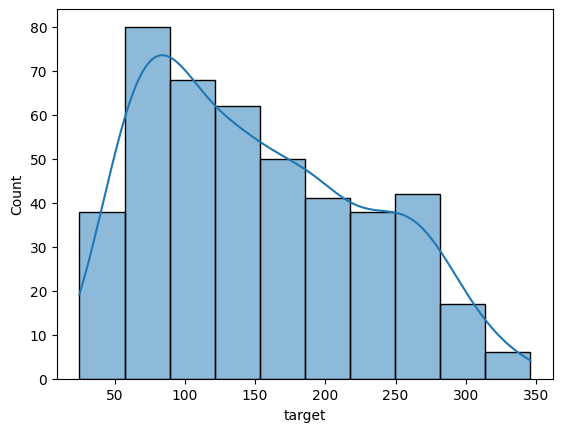

In [4]:
sns.histplot(y, kde = True);

## 2. Coding a Vectorial Gradient Descent

We're modeling a linear regression $\hat{y} = X\beta$

<img src="https://wagon-public-datasets.s3.amazonaws.com/05-Machine-Learning/04-Under-the-Hood/vectorial-gradient.jpg">

First, let's add an "intercept" column of "ones" to our feature matrix X

In [5]:

X = np.hstack((X, np.ones((X.shape[0], 1))))
X.shape

(442, 11)

In [6]:
pd.DataFrame(X).head()

,0,1,2,3,4,5,6,7,8,9,10
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,1.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,1.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,1.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,1.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,1.0


We shall then create a train/test split with `test_size=0.3` and `random_state=1` (so that we all have repeatable results)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state = 1)


Let's recall the definition of the gradient descent algorithm

$$\text{Gradient descent - vector formula}$$
$$\beta^{\color {red}{(k+1)}} = \beta^{\color {red}{(k)}} - \eta \ \nabla L(\beta^{\color{red}{(k)}})$$

The MSE Loss for an OLS regression is

$$L(\beta) = \frac{1}{n}\|X \beta - y\|^2 = \frac{1}{n}(X \beta - y)^T(X \beta - y)$$

and its gradient is
$${\displaystyle \nabla L(\beta)=
{\begin{bmatrix}{\frac {\partial L}{\partial \beta_{0}}}(\beta)\\\vdots \\{\frac {\partial L}{\partial \beta_{p}}}(\beta)\end{bmatrix}} = \frac{2}{n} X^T (X\beta - y) 
}$$

Let's store our main problem parameters below:

In [8]:
# n observations
n = X.shape[0]
n_train = X_train.shape[0]
n_test = X_test.shape[0]

# p features (including the intercept)
p = X.shape[1]

# Gradient Descent hyper-params
eta = .1
n_epochs= 100

We shall then initialise a $\beta$ vector of zeros of shape **p**

In [9]:
beta = np.zeros(p)

beta.shape

(11,)

Using the vectorized formula given above, we may create a Gradient Descent that loops over `n_epochs` to find the best $\beta$ of an OLS using the `train` set

In [10]:
for epoch in range(n_epochs):
    gradient = 2 / n_train * np.dot(X_train.T, (np.dot(X_train, beta) - y_train))
    beta = beta - eta * gradient

In [11]:
print('Best ß: ', beta)

Best ß:  [ 13.88877812   1.6767504   45.64204342  31.67134515  13.17780485
   9.52749193 -28.21620784  30.03382058  41.48427879  27.12324669
 153.73815888]


## Predict

We may now compute predictions on the test set (`y_pred`), and the resulting `loss_test` (MSE loss for OLS).

In [12]:
# Computing y_pred
y_pred_train = X_train.dot(beta)
y_pred_test = X_test.dot(beta)

In [13]:
# Printing test loss and train loss
print('Train Loss:', mean_squared_error(y_train, y_pred_train))
print('Test Loss:', mean_squared_error(y_test, y_pred_test))

Train Loss: 5536.456061612208
Test Loss: 4477.6183367564


## Wrapping these into a function called `gradient_decent`

We may now wrap this logic into a function called `gradient_descent`, which takes as input some (`X_train`, `y_train`, `X_test`, `y_test`, `eta`, `n_epoch`) values, and returns:
- the final value for $\beta$ fitted on the train set
- the values of the `loss_train` at each epoch as a list called `loss_train_history`
- the values of the `loss_test` at each epoch as a list called `loss_test_history`

In [14]:
def gradient_descent(X_train, y_train, X_test, y_test, eta = eta, n_epochs = 100):
    n_train = X_train.shape[0]
    n_test = X_test.shape[0]
    p = X_train.shape[1]

    beta = np.zeros(p)

    loss_train_history = []
    loss_test_history = []

    for epoch in range(n_epochs):
        # GD
        gradients = 2/n_train * X_train.T.dot(X_train.dot(beta) - y_train)
        beta = beta - eta * gradients

        # Computing predictions
        y_pred_train = X_train.dot(beta)
        y_pred_test = X_test.dot(beta)

        # Computing loss histories
        loss_train = 1 / n_train*(y_pred_train - y_train).T.dot(y_pred_train - y_train)
        loss_test = 1 / n_test*(y_pred_test - y_test).T.dot(y_pred_test - y_test)

        loss_train_history.append(loss_train)
        loss_test_history.append(loss_test)

    return beta, loss_train_history, loss_test_history

## Early stopping criteria

We can now plot the loss as a function of epochs, on the train dataset: 
- Trying with `n_epochs=10000` and `eta=0.1` as was initially set
- Zooming in with `plt.ylim(ymin=2800, ymax=3000)` to see the behavior of the Loss Function on the test set

In [15]:
beta, loss_train_history, loss_test_history = gradient_descent(X_train, y_train, X_test, y_test, eta = 0.1, n_epochs = 10000)

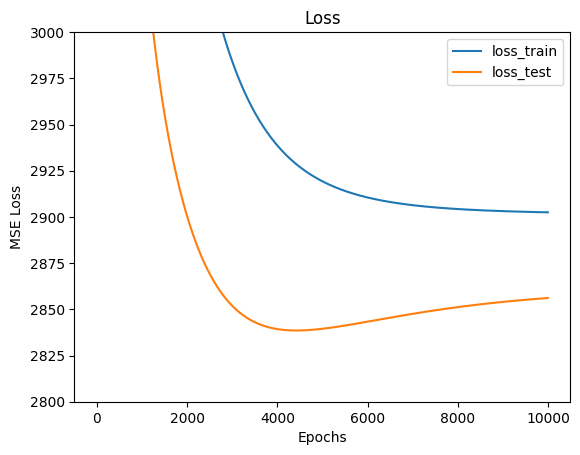

In [16]:
# Plotting train and test histories
plt.plot(loss_train_history, label = 'loss_train')
plt.plot(loss_test_history, label = 'loss_test')

# Setting title and labels
plt.title('Loss')
plt.ylabel('MSE Loss')
plt.xlabel('Epochs')

# Changing limits
plt.ylim(ymin = 2800, ymax = 3000)

# Generating legend
plt.legend()

We could have stopped earlier to get a better score

For that:
- We could decide to stop the GD as soon as the test loss starts to increase again.
- However, we cannot use the "test set" created initially to decide when to stop descending gradient, as this would create data leakage.
- We can create instead a train/test split within the current training set and optimize the early stopping based on the loss of this new test set only. This one is called a validation set.

We shall update the `gradient_descent` method based on the conclusion above

In [17]:
def gradient_descent_early_stopping(X_train, y_train, X_test, y_test, eta = eta, n_epochs = n_epochs):
    n_train = X_train.shape[0]
    n_test = X_test.shape[0]

    p = X_train.shape[1]

    beta = np.zeros(p)

    loss_train_history = []
    loss_test_history = []

    for epoch in range(n_epochs):
        # Computing predictions
        y_pred_train = X_train.dot(beta)
        y_pred_test = X_test.dot(beta)

        # GD
        gradients = 2/n_train * X_train.T.dot(y_pred_train - y_train)
        beta = beta - eta * gradients

        # Computing loss histories
        loss_train = 1 / n_train * (y_pred_train - y_train).T.dot(y_pred_train - y_train)
        loss_test = 1 / n_test * (y_pred_test - y_test).T.dot(y_pred_test - y_test)

        # Breaking the loop to escape as soon as test loss increases
        if epoch > 0:
            if loss_test > loss_test_history[-1]:
                break

        loss_train_history.append(loss_train)
        loss_test_history.append(loss_test)

    return beta, loss_train_history, loss_test_history

Let us now create the train/val set and trying to improve the MSE with early stopping, using `random_state = 1`

It should stop earlier than before.

In [18]:
X_train_train, X_val, y_train_train, y_val = train_test_split(X_train, y_train, random_state = 1)

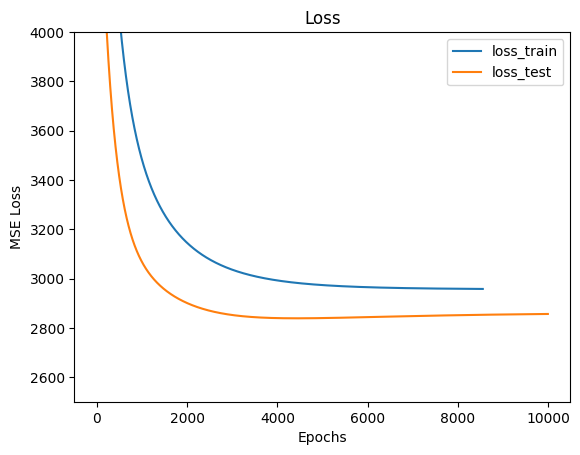

In [19]:
beta_es, loss_train_history, loss_val_history = gradient_descent_early_stopping(X_train_train, y_train_train, X_val, y_val, n_epochs = 10000, eta = .1)

# Plotting train and test histories
plt.plot(loss_train_history, label = 'loss_train')
plt.plot(loss_test_history, label = 'loss_test')

# Setting title and labels
plt.title('Loss')
plt.ylabel('MSE Loss')
plt.xlabel('Epochs')

# Changing limits
plt.ylim(ymin = 2500, ymax = 4000)

# Generating legend
plt.legend()

## Mini-Batch Descent

We shall now modify the gradient_descent function into a `minibatch_gradient_descent` one.

In [20]:
def minibatch_gradient_descent(X_train, y_train, X_test, y_test, batch_size = 16, eta = eta, n_epochs = n_epochs):
    n_train = X_train.shape[0]
    n_test = X_test.shape[0]

    p = X_train.shape[1]

    beta = np.zeros(p)

    loss_train_history = []
    loss_test_history = []

    if isinstance(y_train, pd.Series):
        y_train = y_train.to_numpy()

    for epoch in range(n_epochs):
        # Shuffling the (X_train, y_train) dataset
        indices = np.random.permutation(n_train)
        X_train = X_train[indices]
        y_train = y_train[indices]


        # Looping over the dataset in mini-batches, and for each mini-batch update beta
        for i in range(0, n_train, batch_size): # i = [0, 15, 31, ... n]
            # Slicing "from i to i + batch size"
            X_mini = X_train[i:i + batch_size]
            y_mini = y_train[i:i + batch_size]

            # Computing mini-batch y_pred
            y_pred_mini = X_mini.dot(beta)

            # GD
            gradients = 2 / batch_size * X_mini.T.dot(y_pred_mini - y_mini)
            beta = beta - eta * gradients

        # Keeping track of loss histories per epoch
        y_pred_train = X_train.dot(beta)
        y_pred_test = X_test.dot(beta)

        loss_train = 1 / n_train * (y_pred_train - y_train).T.dot(y_pred_train - y_train)
        loss_test = 1 / n_test * (y_pred_test - y_test).T.dot(y_pred_test - y_test)

        loss_train_history.append(loss_train)
        loss_test_history.append(loss_test)

    return beta, loss_train_history, loss_test_history

Let us now plot the evolution of train and val losses per epoch. What if we chose minibatch = 1?

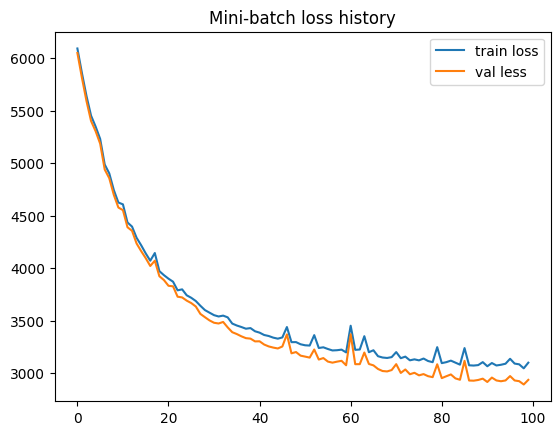

In [21]:
beta_mini, loss_train_history_mini, loss_val_history_mini = minibatch_gradient_descent(
    X_train_train,
    y_train_train,
    X_val,
    y_val,
    batch_size = 8,
    n_epochs = 100
)

plt.plot(loss_train_history_mini, label = 'train loss')
plt.plot(loss_val_history_mini, label = 'val less')

plt.title('Mini-batch loss history')
plt.legend()

To avoid early stopping too early due to the stochastic nature of the mini-batch descent, we could add a "patience" term to stop only after the val loss is increased for a sustained period of "patience" # of epochs.

## Conclusion: a new way to check for overfitting

<img src="https://wagon-public-datasets.s3-eu-west-1.amazonaws.com/05-Machine-Learning/04-Under-the-Hood/underfitting_overfitting_at_a_glance.webp" width=800>